In [1]:
import pandas as pd
from pyarrow.parquet import ParquetFile
import dask.dataframe as dd
import os
import xarray as xr
import ujson
import pprint

In [2]:
# These fs options don't work for http... beware!
so = dict(mode="rb", anon=True, default_fill_cache=False, default_cache_type="first")

In [3]:
def gen_json(u, fs, outf=None):
    with fs.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)
        p = u.split("/")
        date = p[3]
        fname = p[5]
        if outf:
            # outf = f'{json_dir}{date}.{fname}.json'
            with open(outf, "wb") as f:
                f.write(ujson.dumps(h5chunks.translate()).encode())
        else:
            return h5chunks.translate()

In [4]:
# dir_files = [os.path.join("../short_range_18files", files) for files in os.listdir("../short_range_18files")]
# dir_files = [os.path.join("short_range_2files", files) for files in os.listdir("short_range_2files")]
# print(dir_files)
dir_files = [
    "nwm.t00z.short_range.channel_rt.f001.conus.nc",
    "nwm.t00z.short_range.channel_rt.f002.conus.nc",
    "nwm.t00z.short_range.channel_rt.f003.conus.nc",
    "nwm.t00z.short_range.channel_rt.f004.conus.nc",
    "nwm.t00z.short_range.channel_rt.f005.conus.nc",
    "nwm.t00z.short_range.channel_rt.f006.conus.nc",
    "nwm.t00z.short_range.channel_rt.f007.conus.nc",
    "nwm.t00z.short_range.channel_rt.f008.conus.nc",
    "nwm.t00z.short_range.channel_rt.f009.conus.nc",
    "nwm.t00z.short_range.channel_rt.f010.conus.nc",
    "nwm.t00z.short_range.channel_rt.f011.conus.nc",
    "nwm.t00z.short_range.channel_rt.f012.conus.nc",
    "nwm.t00z.short_range.channel_rt.f013.conus.nc",
    "nwm.t00z.short_range.channel_rt.f014.conus.nc",
    "nwm.t00z.short_range.channel_rt.f015.conus.nc",
    "nwm.t00z.short_range.channel_rt.f016.conus.nc",
    "nwm.t00z.short_range.channel_rt.f017.conus.nc",
    "nwm.t00z.short_range.channel_rt.f018.conus.nc",
]

In [5]:
import fsspec
import xarray as xr
from kerchunk.hdf import SingleHdf5ToZarr

fs = fsspec.filesystem("gcs", anon=True)

# https://storage.googleapis.com/national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc
# gcs_url = "gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc"
gcs_url = "gcs://national-water-model/nwm.20220911/short_range/"

sr_h5 = []
for f in dir_files:
    print(f)
    sr_h5.append(gen_json(gcs_url + f, fs))

nwm.t00z.short_range.channel_rt.f001.conus.nc
nwm.t00z.short_range.channel_rt.f002.conus.nc
nwm.t00z.short_range.channel_rt.f003.conus.nc
nwm.t00z.short_range.channel_rt.f004.conus.nc
nwm.t00z.short_range.channel_rt.f005.conus.nc
nwm.t00z.short_range.channel_rt.f006.conus.nc
nwm.t00z.short_range.channel_rt.f007.conus.nc
nwm.t00z.short_range.channel_rt.f008.conus.nc
nwm.t00z.short_range.channel_rt.f009.conus.nc
nwm.t00z.short_range.channel_rt.f010.conus.nc
nwm.t00z.short_range.channel_rt.f011.conus.nc
nwm.t00z.short_range.channel_rt.f012.conus.nc
nwm.t00z.short_range.channel_rt.f013.conus.nc
nwm.t00z.short_range.channel_rt.f014.conus.nc
nwm.t00z.short_range.channel_rt.f015.conus.nc
nwm.t00z.short_range.channel_rt.f016.conus.nc
nwm.t00z.short_range.channel_rt.f017.conus.nc
nwm.t00z.short_range.channel_rt.f018.conus.nc


In [6]:
%%time
fds = []
for xj in sr_h5:
    backend_args = {
        "consolidated": False,
        "storage_options": {
            "fo": xj,
            # Adding these options returns a properly dimensioned but otherwise null dataframe
            # "remote_protocol": "https",
            # "remote_options": {'anon':True}
        },
    }
    fds.append(
        xr.open_dataset(
            "reference://",
            engine="zarr",
            mask_and_scale=False,
            backend_kwargs=backend_args,
        )
    )
    
#dataset
ds = xr.concat(fds, dim="time")
ds

#dataframe
df = ds["streamflow"].to_dataframe()
df

CPU times: user 9.03 s, sys: 2.89 s, total: 11.9 s
Wall time: 21.5 s


streamflow
time                feature_id            
2022-09-11 01:00:00 101                 18
                    179                  1
                    181                  1
                    183                  1
                    185                  1
...                                    ...
2022-09-11 18:00:00 1180001800           0
                    1180001801           0
                    1180001802           0
                    1180001803           0
                    1180001804           0

[49981284 rows x 1 columns]

In [10]:
# Write parquet file
%%time
# df = pd.Series.to_frame(df)

df.to_parquet(
    "../data/parquet_all_feature_ids.gzip", engine="pyarrow", compression="gzip"
)

CPU times: user 54.5 s, sys: 751 ms, total: 55.3 s
Wall time: 55.5 s


In [11]:
ParquetFile("../data/parquet_all_feature_ids.gzip").metadata  #  num_columns: 3

  created_by: parquet-cpp-arrow version 7.0.0
  num_columns: 3
  num_rows: 49981284
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 2374

### Query 1 feature id

CPU times: user 26.8 s, sys: 6.14 s, total: 33 s
Wall time: 32.9 s


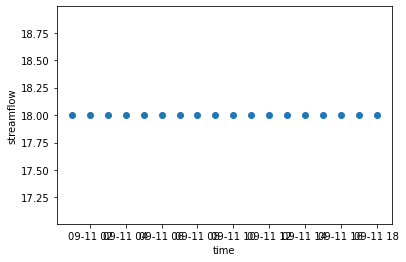

In [12]:
# Read parquet file
%%time
#pip install pyarrow, fastparquet
import dask.dataframe as dd
data_1 = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip", engine='pyarrow', columns=['streamflow']
)
result_1=data_1.compute()
result_1.sort_index(inplace=True)
result_1=result_1.loc[(slice(None), [101]), :]

r_xa_1 = result_1.to_xarray()
#r_xa
r_xa_1.plot.scatter("time", "streamflow")

### Query 100 feature id

CPU times: user 31.9 s, sys: 6.88 s, total: 38.8 s
Wall time: 38.6 s


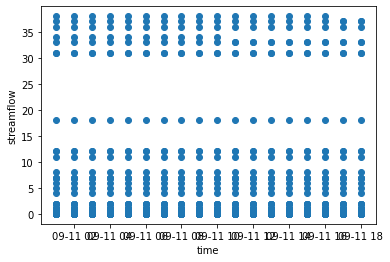

In [25]:
%%time
data_100 = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip", engine='pyarrow', columns=['streamflow']
)
result_100=data_100.compute()
result_100.sort_index(inplace=True)
result_100=result_100.loc[:, 100:1032, :]

r_xa_100 = result_100.to_xarray()
#r_xa
r_xa_100.plot.scatter("time", "streamflow")

### Query 10,000 feature_ids

In [ ]:
%%time
data_10000 = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip", engine='pyarrow', columns=['streamflow']
)
result_10000=data_10000.compute()
result_10000.sort_index(inplace=True)
result_10000=result_10000.loc[:, 100:252765, :]

r_xa_10000 = result_10000.to_xarray()
#r_xa
r_xa_10000.plot.scatter("time", "streamflow")

CPU times: user 32.4 s, sys: 6.16 s, total: 38.6 s
Wall time: 38.4 s


In [ ]:
result_10000

### Query 100,000 feature_ids

CPU times: user 32.3 s, sys: 6.12 s, total: 38.4 s
Wall time: 38.3 s


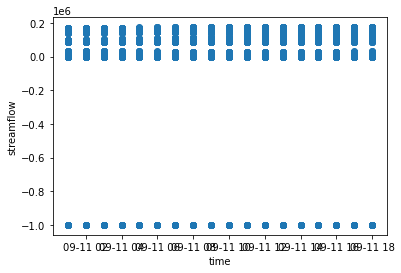

In [20]:
%%time
data_100000 = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip", engine='auto', columns=['streamflow']
)
result_100000=data_100000.compute()
result_100000.sort_index(inplace=True)
result_100000=result_100000.loc[:, 100:1122643, :]

r_xa_100000 = result_100000.to_xarray()
#r_xa
r_xa_100000.plot.scatter("time", "streamflow")